## OpenPIV tutorial of all test cases

In [12]:
from openpiv import tools, process, scaling, validation, filters
import numpy as np
import glob
%matplotlib inline

In [13]:
def openpiv_default_run(im1,im2):
    """ default settings for OpenPIV analysis using
    extended_search_area_piv algorithm for two images
    
    Inputs:
        im1,im2 : str,str = path of two image
    """
    frame_a  = tools.imread(im1)
    frame_b  = tools.imread(im2)

    u, v, sig2noise = process.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=32, overlap=8, 
                                                       dt=1, search_area_size=64, 
                                                       sig2noise_method='peak2peak' )
    x, y = process.get_coordinates( image_size=frame_a.shape, window_size=32, overlap=8 )
    u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 1.3 )
    u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
    x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 1 )
    tools.save(x, y, u, v, mask, list_of_images[0]+'.txt' )
    fig,ax = tools.display_vector_field(list_of_images[0]+'.txt',on_img=True,image_name=list_of_images[0],scaling_factor=1,ax=None)

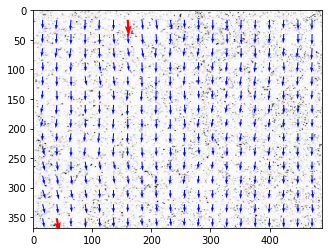

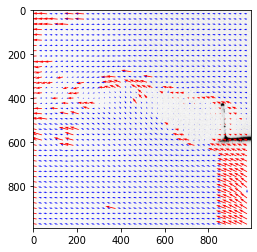

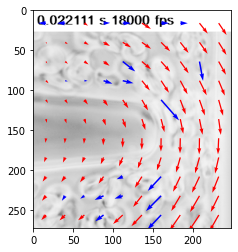

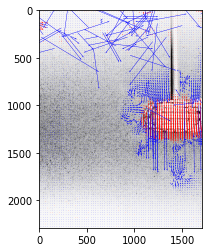

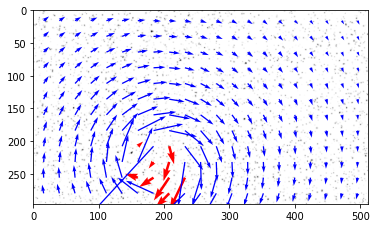

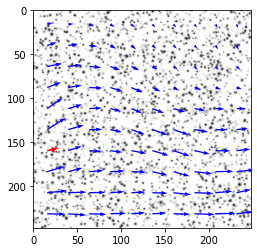

In [14]:
alist_filter = ['jpg','bmp','png','tif','tiff']


# all test cases in /openpiv/examples/
list_of_tests = glob.glob('../test*')
list_of_tests.sort()

list_of_images = []
for test in list_of_tests:
    
    list_of_files = glob.glob(test+'/*.*')
    list_of_files.sort()
    list_of_images = [f for f in list_of_files if f[-3:] in alist_filter]
    
    openpiv_default_run(list_of_images[0],list_of_images[1])
